In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import resnet18
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd

2024-07-03 13:08:38.714012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 13:08:40.143986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Bridge2AI dataset

In [2]:
dataset = VBAIDataset('./bids_with_sensitive_recordings')


### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [3]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)

train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))

train: 142
val: 18
test: 18


### Create PyTorch dataset of prolonged vowel audios with age and airway stenosis labels

In [4]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [5]:
import torch
import torch.nn.functional as F

class MySpecgramDataset(torch.utils.data.Dataset):
	def __init__(self, identities, dataset, person_session_pairs, segment_size=3):
		self.segment_size = segment_size
		
		# get age and airway stenosis classification for all subjects
		participant_df = dataset.load_and_pivot_questionnaire('participant')
		age_df = participant_df[['record_id', 'age']].to_numpy()
		airway_stenosis_df = participant_df[['record_id', 'airway_stenosis']].to_numpy()
        
		age_dict = {}
		for person_id, age in age_df:
			age_dict[str(person_id)] = float(age)
		airway_stenosis_dict = {}
		for person_id, airway_stenosis in airway_stenosis_df:
			airway_stenosis_dict[str(person_id)] = float(airway_stenosis)

		# get all prolonged vowel audios
		self.audio_files = []
		self.age = []
		self.airway_stenosis = []
        
		for person_id, session_id in person_session_pairs:
			if person_id not in identities:
				continue
			vowel_audios = [str(x) for x in dataset.find_audio(person_id, session_id) if str(x).endswith('-Prolonged-vowel.wav')]
			self.audio_files += vowel_audios
			self.age += [age_dict[person_id]]*len(vowel_audios)
			self.airway_stenosis += [airway_stenosis_dict[person_id]]*len(vowel_audios)

	def __len__(self):
		return len(self.audio_files)

	def __getitem__(self, idx):
		audio = Audio.from_file(self.audio_files[idx])
		audio = audio.to_16khz()
		# get middle K seconds if audio is too long, pad with zeros if it is too short
		if audio.signal.size(0) > self.segment_size*16000:
			d = (audio.signal.size(0)-self.segment_size*16000)//2
			audio.signal = audio.signal[d:d+self.segment_size*16000]
		else:
			audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)

		win_length = 30
		hop_length = 10
		nfft = 512
		features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
		features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))
		
		# I add this to reshape the image
		features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

		

		return {'signal': features_specgram, 'age': self.age[idx], 'airway_stenosis': self.airway_stenosis[idx]}

tensor([80., 39., 58., 65., 72., 68., 31., 74.], dtype=torch.float64) tensor([1., 1., 1., 0., 0., 0., 1., 1.], dtype=torch.float64)
image shape:  torch.Size([256, 256])
Batch shape:  torch.Size([8, 256, 256])


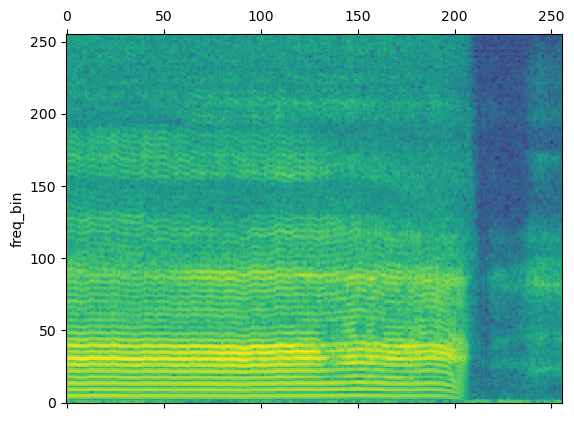

In [6]:
train_dataset = MySpecgramDataset(train_identities, dataset, person_session_pairs)
val_dataset = MySpecgramDataset(val_identities, dataset, person_session_pairs)
test_dataset = MySpecgramDataset(test_identities, dataset, person_session_pairs)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
	print(batch['age'], batch['airway_stenosis'])
	print("image shape: ", batch['signal'][0].T.shape)
	print("Batch shape: ", batch['signal'].shape)
	plot_spectrogram(batch['signal'][0].T)
	
	break

### Change batch size from (8, 256, 256) to (18, 8, 256, 256)
I did this to see if now it is compatiable with the model or not. Because in the example they used image with this shape: (20, 3, 256, 256). 

In [7]:
import torch
import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram):
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title("Spectrogram")
    plt.ylabel("Frequency bins")
    plt.xlabel("Time")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Initialize an empty list to collect the batches
all_batches = []

# Define the desired shape after padding
desired_shape = (8, 256, 256)

# Iterate through the data loader
for i, batch in enumerate(train_dataloader):
    if i >= 19:
        break
    
    signal = batch['signal']
    
    # Check if the batch has the expected number of samples
    if signal.shape[0] != desired_shape[0]:
        print(f"Skipping batch {i} because it has {signal.shape[0]} samples but expected {desired_shape[0]}")
        continue
    
    # Pad or reshape each signal to match desired_shape
    if signal.shape != desired_shape:
        # Assuming padding is necessary
        padded_signal = torch.nn.functional.pad(signal, (0, 10))
    else:
        padded_signal = signal
    
    # Append the padded batch to the list
    all_batches.append(padded_signal)

# Stack all valid batches along a new dimension
combined_tensor = torch.stack(all_batches, dim=0)

print("Combined Tensor shape: ", combined_tensor.shape)

# Plot the spectrogram of the first signal in the first batch
#plot_spectrogram(combined_tensor[0, 0].T)


Skipping batch 18 because it has 1 samples but expected 8
Combined Tensor shape:  torch.Size([18, 8, 256, 256])


### ViT model 

In [8]:
import torch
from vit_pytorch import ViT
from vit_pytorch.mpp import MPP

model = ViT(
    image_size=256,
    patch_size=32,
    num_classes=2,
    dim=1024,
    depth=6,
    heads=8,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
    channels=1
)

mpp_trainer = MPP(
    transformer=model,
    patch_size=32,
    dim=1024,
    mask_prob=0.15,          # probability of using token in masked prediction task
    random_patch_prob=0.30,  # probability of randomly replacing a token being used for mpp
    replace_prob=0.50,  
    channels=1# probability of replacing a token being used for mpp with the mask token
)

opt = torch.optim.Adam(mpp_trainer.parameters(), lr=3e-4)

def sample_unlabelled_images():
    return torch.FloatTensor(20, 3, 256, 256).uniform_(0., 1.)

for i in range(17):
    images = combined_tensor[i]
    loss = mpp_trainer(images.view(-1,1,images.size(1),images.size(2)))
    opt.zero_grad()
    loss.backward()
    opt.step()

# save your improved network
torch.save(model.state_dict(), './pretrained-net.pt')

In [76]:
torch.save(model.state_dict(), './vit_transformer_model.pth')

### Training

my old code for transformer. I did not used it 

In [10]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(batch['signal'].view(-1,1,batch['signal'].size(1),batch['signal'].size(2)))
        for i in range(len(batch['signal'])):
            
            if batch['airway_stenosis'][i] == 1 and outputs[i][1].item() > 0.5:
                acc += 1
            if batch['airway_stenosis'][i] == 0 and outputs[i][0].item() > 0.5:
                acc += 1

    return acc/len(dataloader.dataset)	

num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
	
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()

        signal = batch['signal']
        outputs = model(signal.view(-1,1,signal.size(1),signal.size(2)))
        loss = torch.nn.functional.cross_entropy(outputs, batch['airway_stenosis'].long())
        closs += [loss.item()]*len(batch['signal'])
        loss.backward()
        optimizer.step()

    val_acc = eval(model, val_dataloader)
    print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(model, train_dataloader), val_acc))

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './model.pth')
        print('Saved!')


Epoch:1 TrainLoss:0.7330 TrainACC:0.6828 ValACC:0.5789
Saved!
Epoch:2 TrainLoss:0.6992 TrainACC:0.6828 ValACC:0.5789
Saved!
Epoch:3 TrainLoss:0.6059 TrainACC:0.9862 ValACC:0.9474
Saved!
Epoch:4 TrainLoss:0.5679 TrainACC:0.9655 ValACC:0.8947
Epoch:5 TrainLoss:0.3834 TrainACC:0.8966 ValACC:0.5789
Epoch:6 TrainLoss:0.2046 TrainACC:0.9586 ValACC:0.6842
Epoch:7 TrainLoss:0.1399 TrainACC:0.9862 ValACC:0.7895
Epoch:8 TrainLoss:0.1106 TrainACC:0.9793 ValACC:0.8947
Epoch:9 TrainLoss:0.1019 TrainACC:1.0000 ValACC:0.8947
Epoch:10 TrainLoss:0.0146 TrainACC:1.0000 ValACC:0.8947
Epoch:11 TrainLoss:0.0156 TrainACC:0.9931 ValACC:0.7368
Epoch:12 TrainLoss:0.0094 TrainACC:1.0000 ValACC:0.6842
Epoch:13 TrainLoss:0.0300 TrainACC:1.0000 ValACC:0.6842
Epoch:14 TrainLoss:0.3131 TrainACC:0.9655 ValACC:0.6316
Epoch:15 TrainLoss:0.1780 TrainACC:0.9862 ValACC:0.6316
Epoch:16 TrainLoss:0.1243 TrainACC:1.0000 ValACC:0.6842
Epoch:17 TrainLoss:0.0117 TrainACC:1.0000 ValACC:0.6842


KeyboardInterrupt: 

### Testing

In [15]:

test_acc = eval(model, test_dataloader)
print('TestACC:{:.4f}'.format(test_acc))

TestACC:0.6875


In [20]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(batch['signal'].view(-1,1,batch['signal'].size(1),batch['signal'].size(2)))
        for i in range(len(batch['signal'])):
            
            if batch['airway_stenosis'][i] == 1 and outputs[i][1].item() > 0.5:
                acc += 1
            if batch['airway_stenosis'][i] == 0 and outputs[i][0].item() > 0.5:
                acc += 1

    return acc/len(dataloader.dataset)	

model.load_state_dict(torch.load('./model.pth'))

accuracy = eval (model, test_dataloader)
print(f'test accuracy: {accuracy:.4f}')


test accuracy: 0.6875
